# Optimizing Stock Portfolio Allocation <a class='tocSkip'>

## Sang-Yun Oh <a class='tocSkip'>

## Installing Packages in Python

* Default package source for `pip` command is Python Package Index (PyPI)  
    e.g., https://pypi.org/project/yfinance/
* Can also install from github repository: 
    https://pypi.org/project/yfinance/

In [1]:
# install from pypi
!pip install yfinance

In [2]:
# install from github
# ! pip install git+https://github.com/ranaroussi/yfinance

In [3]:
!pip install cvxpy

In [4]:
import pandas as pd
import numpy as np
import pickle
import cvxpy

## Introduction to Portfolio Theory

### Stock Prices vs. Returns 

* Model stock returns as random variables
* Returns depend on change in stock prices:  
    $$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Linear approximation of $\log(1+x)\approx x$ when $x$ is small. 
* Since daily stock returns are small,
$$ R_t \approx \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$

* Compute the log-returns then difference of log prices (converting data)

### Modeling Stock Returns

* In classical portfolio theory, stock returns are normally distributed
* Daily returns of two stocks: $R_A$ and $R_B$ of two stocks $A$ and $B$
* Jointly normally distributed: bivariate normal distribution: 
$$\begin{aligned}
\begin{pmatrix}
R_A\\ R_B
\end{pmatrix}
\sim
N\left(
\begin{pmatrix}
\mu_A\\ \mu_B
\end{pmatrix},
\begin{pmatrix}
\sigma_A^2 & \sigma_{AB}\\
\sigma_{AB} & \sigma_B^2
\end{pmatrix}
\right)
\end{aligned}$$

* Marginal distributions: 
$$R_A \sim N(\mu_A,\sigma_A^2) \text{, and } R_B \sim N(\mu_B,\sigma_B^2),$$
* Covariance and correlation are
$$\sigma_\text{AB} = \text{Cov}(R_A,R_B) \text{, and } \rho_\text{AB} = \frac{\sigma_\text{AB}}{\sigma_A\sigma_B}$$

### Modeling Portfolio Returns

* Two-stock portfolio: Return for the portfolio $R_p$ is 
$$R_p = R_A x_A + R_B x_B,$$
* Allocations: $x_A$ and $x_B$ are proportions of stocks $A$ and $B$ such that  
$$x_A + x_B = 1$$

* $R_p$ is also normally distributed with following mean and variance:
$$\begin{aligned}
\mu_p &= \text{E}(R_p) \\
    &= \text{E}(R_B)\, x_A + \text{E}(R_B)\, x_B\\
    &= \mu_A x_A + \mu_B x_B\\
\sigma_p^2 &= \text{Var}(R_p) \\
    &= \text{E}\left((R_p - \text{E}(R_p))^2\right) \\
    &= \sigma_A^2\,x_A^2 + \sigma_B^2\,x_B^2 + 2\sigma_{AB}x_A x_B.
\end{aligned}
$$
Note that $\sigma_{AB} = \rho_{AB}\sigma_A\sigma_B$.
* Distribution of the portfolio return is
$$ R_p \sim N(\mu_p, \sigma_p^2) $$

### Hedging Portfolio Risk

* Mean return ($\mu_p$): weighted average of returns
* Risk ($\sigma_p^2$):  Risk of $p$ can be decreased if $\rho<0$
* Hedge risk by having negatively correlated stocks

## Toy Example: Simulating $R_A$ and $R_B$

* $R_A\sim N(0.15, 0.1^2)$ and $R_B\sim N(0.1, 0.05^2)$
* Correlation: $\rho_{AB} = -0.15$
* Portfolio weight distributed evenly: i.e. $x_A = x_B = 0.5$

In [5]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

### Generate random returns

In [6]:
def simulate_returns(A, B, correlation, size=100):
    
    from numpy import sqrt
    from numpy.random import multivariate_normal
    from pandas import DataFrame
    
    # what could go wrong with rounding errors?
    assert(A['proportion'] + B['proportion'] == 1) 

    # construct bivariate normal random variable
    mu = [A['mu'], B['mu']]
    sigma = [[A['sig']**2, correlation*A['sig']*B['sig']],
             [correlation*A['sig']*B['sig'], B['sig']**2]]
    
    # get random observations
    R = multivariate_normal(mu, sigma, size)
    Rp = R[:,0]*A['proportion'] + R[:,1]*B['proportion']
    
    # simulated returns
    R = np.hstack((R, Rp.reshape((-1,1))))
    
    # theoretical properties of portfolio returns
    p = {
        'mu': A['mu']*A['proportion'] + B['mu']*B['proportion'],
        'sig': sqrt(
            A['sig']**2*A['proportion']**2 + B['sig']**2*B['proportion']**2 
            + 2*correlation*A['sig']*B['sig']*A['proportion']*B['proportion'])
        }
    
    return p, DataFrame(R, columns=['A', 'B', 'p'])

### Empirical Returns

In [7]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

p, R = simulate_returns(A, B, -0.9, 10000)

print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))

print('cor(R_A, R_B) = %1.4f' % np.corrcoef(R.A, R.B)[1,0])

A: mean = 0.15, std = 0.1005
B: mean = 0.10, std = 0.0503
p: mean = 0.13, std = 0.0297
cor(R_A, R_B) = -0.9011


### Empirical Portfolio Returns

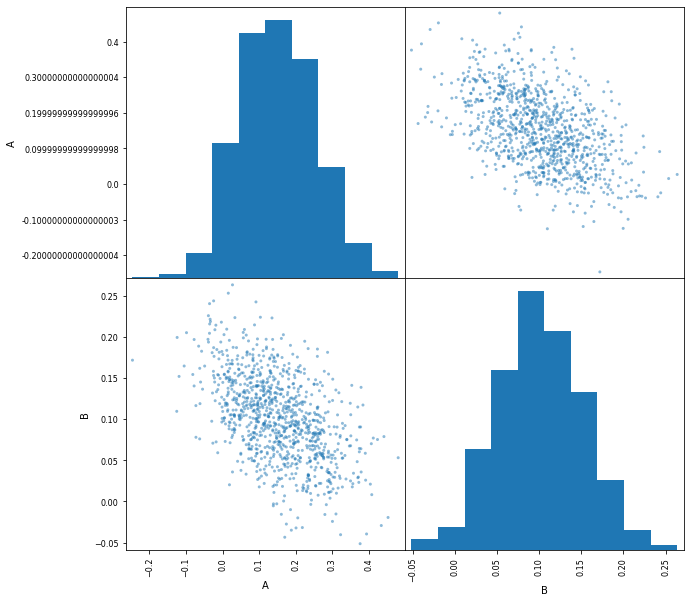

In [8]:
p, R = simulate_returns(A, B, -0.5, 1000)
pd.plotting.scatter_matrix(R.loc[:,['A','B']], figsize=(10,10));

### Theoretical returns

Calculate the volatility ($\sigma^2$) and expected returns ($\mu$):

In [9]:
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('p: mean = %1.2f, std = %1.4f' % (p['mu'], p['sig']))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500
p: mean = 0.12, std = 0.0433


### Independent Portfolio Theoretical returns

If stocks A and B were independent

In [10]:
p, R = simulate_returns(A, B, -0.9, 10000)
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('')
print('p: mean = %1.2f, std = %1.4f (if A and B are correlated )' % (p['mu'], p['sig']))
print('p: mean = %1.2f, std = %1.4f (if A and B are independent)' % (p['mu'], np.sqrt(0.5**2*A['sig']**2 + 0.5**2*B['sig']**2)))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500

p: mean = 0.12, std = 0.0296 (if A and B are correlated )
p: mean = 0.12, std = 0.0559 (if A and B are independent)


#### Empirical (Data) Properties 

In [11]:
print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))
print('corr(A, B) = %1.4f' % np.corrcoef(R.A, R.B)[0,1])

A: mean = 0.15, std = 0.1012
B: mean = 0.10, std = 0.0507
p: mean = 0.12, std = 0.0298
corr(A, B) = -0.9026


### Efficient frontier of portfolios

* Consider all values of $x_A$ and $x_B$

* For each combination, compute $\mu_p$ and $\sigma_p^2$.

In [12]:
xa = np.linspace(-1, 2, num=101)
pf = pd.DataFrame({'xa':xa, 'xb':1-xa})

# pf, R = simulate_returns(A, B, -0.5, 10000)

corr = -0.5
pf['mu'] = A['mu'] * pf.xa + B['mu'] * pf.xb
pf['sig2'] = ((A['sig']**2 * pf.xa**2) + (B['sig']**2 * pf.xb**2) + (2 * corr * A['sig'] * B['sig'] * pf.xa * pf.xb))

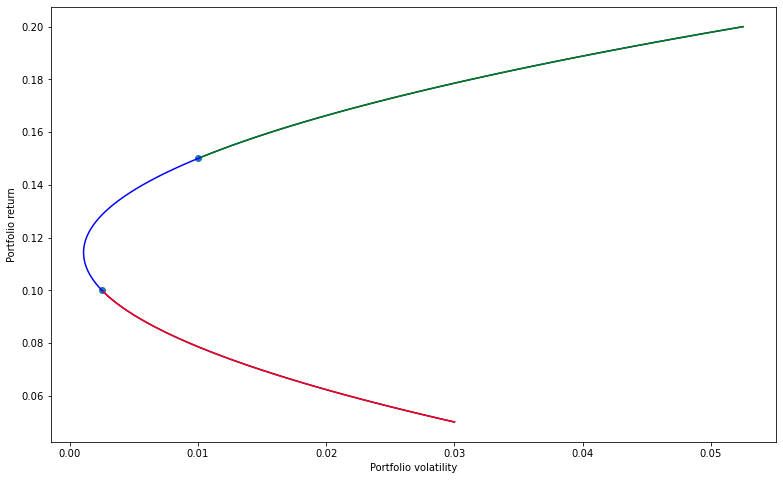

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(pf.sig2, pf.mu, color='b')
plt.plot(pf.sig2[pf.xa<0], pf.mu[pf.xa<0], color='r') # sell stock A to fund purchase of stock B
plt.plot(pf.sig2[pf.xb<0], pf.mu[pf.xb<0], color='g') # sell stock B to fund purchase of stock A
plt.scatter([A['sig']**2, B['sig']**2], [A['mu'], B['mu']])
ax.set_xlabel('Portfolio volatility')
ax.set_ylabel('Portfolio return')
plt.show(p)

* Line is called efficient frontier
* Represents the lower boundary of achievable volatility
* Return and volatility of $A$ and $B$

#### Long and short positions

* Note that `xa` can be negative
* Positive $x_A$ : _long position_ for stock A and indicates a purchase
* Negative $x_A$ : _short position_ stock A and indicates a sale
* _You are selling stocks that you do not own with the expectation that the price of the stock will fall_
* Shorting allows for higher long positions on other stocks.

#### Minimum variance portfolio (MVP)

What is the point at the tip of the parabola? This point indicates what is called the minimum variance portfolio that, regardless of the return, has the minimum volatility. Minimum variance portfolio (MVP) has the minimum volatility of any portfolio achievable.

It can be shown that minimum variance portfolio would have the following allocation $x_A$:

$$x_A = \frac{\sigma_B^2-\sigma_\text{AB}^2}{\sigma_A^2 + \sigma_B^2 – \sigma_\text{AB}^2}$$

The mathematical problem to solve for the minimum variance portfolio can be stated as follows:
$$ \min_{x_A,x_B}\ \ \sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B\\
\text{such that }x_A + x_B = 1$$
Here, $\sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B$ is called the objective function, and $x_A + x_B = 1$ is called the constraint.

The constraint has to be satisfied exactly, and objective wants to be minimized with the freedom of changing the values of $x_A$ and $x_B$.

### Using `cvxpy` for numerical optimization

Calculating analytical solutions is not always possible. There are ways to compute solutions numerically. Although out of scope of our class, a large field in applied math called optimization. The tools from this area allow us to compute solutions for problems such as the one we have here. (For more information, visit the 

### Higher dimensional portfolios

In higher dimensions, the portfolio equantion is written in terms of vectors and matrices. For example, suppose we construct a portfolio consisting of $s$-assets. The portfolio allocation can be written as,
$$\mathbf{1}^\intercal x = 1,$$
where $x$ is an $s$-vector whose sum adds up to 1: i.e., $x_1 + x_2 + \cdots + x_s = 1$.

The portfolio volatility in matrix-vector form looks like:
$$
\begin{pmatrix}x_1 & x_2 & \cdots & x_s\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1s}\\
\sigma_{21} & \sigma_2^2 & \cdots & \sigma_{2s}\\
\vdots & \vdots & & \vdots \\
\sigma_{s1} & \sigma_{s2} & \cdots & \sigma_s^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2 \\ \vdots \\ x_s\end{pmatrix}.
$$
To verify the two stock example result, we check $\sigma_p^2$:
$$
\sigma_p^2 = \begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12}\\
\sigma_{21} & \sigma_2^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2\end{pmatrix} = 
\begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 x_1 + \sigma_{12} x_2\\
\sigma_{21} x_1 + \sigma_2^2 x_2\\
\end{pmatrix} = 
\sigma_1^2 x_1^2 + \sigma_2^2 x_2^2 + \sigma_{12} x_1 x_2,
$$
which matches the result from before.

With this notation, we can re-write the problem.

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mathbf{1}^\intercal x = 1,$$

It can be shown that the optimal solution to this problem is,
$$
x^* = (\mathbf{1}^\intercal\Sigma^{-1}\mathbf{1})^{-1}\Sigma^{-1}\mathbf{1}
$$.

There are many variations of this problem. In fact the minimum variance portfolio is special case of a more general problem

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

Note that in all of the above problems, the measure of $\mu^*$, expected returns, and covariance matrix have to be provided. In practice, these quantities are estimated from data.

## Portfolio Allocation: Dow Jones component stocks

Stock data can have irregularities such as missing data due stocks being added and removed from the index. Some examples are
* Alcoa Corp. (AA) was removed in 2013
* Apple (AAPL) was added in 2015
* E.I. du Pont de Nemours & Company (DD) was removed and replaced with Dow du Pont (DWDP) as a continuation in 2017

For simplicity the stocks we will use are based on the most recent DJIA constituent companies 

In [14]:
dowjones_components = [
    'AAPL','AXP','BA','BAC','CAT',
    'CSCO','CVX','DD','DIS','GE',
    'HD','HPQ','IBM','INTC','JNJ',
    'JPM','KO','MCD','MMM',
    'MRK','MSFT','PFE','PG','T',
    'TRV','VZ','WMT','XOM'
]

symbols = pd.read_csv('data/tickers.csv').set_index('code')

import yfinance as yf
rawdata = yf.download(dowjones_components, start="2000-01-01", end="2022-10-31")
rawdata.head()

[*********************100%***********************]  28 of 28 completed


Adj Close                                                         \
                AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  0.850643  33.436104  25.940285  13.356878  13.171323  38.065071   
2000-01-04  0.778926  32.173595  25.899946  12.564081  13.002030  35.929550   
2000-01-05  0.790324  31.356422  27.513651  12.701962  13.306756  35.819477   
2000-01-06  0.721931  31.995262  27.796032  13.787753  13.983953  35.225052   
2000-01-07  0.756128  32.461098  28.602896  13.425812  14.441051  37.294529   

                                                         ...   Volume  \
                  CVX         DD        DIS          GE  ...      MMM   
Date                                                     ...            
2000-01-03  17.849821  29.800083  23.115253  164.768661  ...  2173400   
2000-01-04  17.849821  28.985552  24.469284  158.177887  ...  2713800   
2000-01-05  18.169998  29.926455  25.484812  157.903275  ...  3699400   
2000-01-06  18.943766  30.769075  24.469284  160.014435  ...  5975800   
2000-01-07  19.277287  31.457182  24.082420  166.210388  ...  4101200   

                                                                              \
                 MRK      MSFT       PFE       PG         T     TRV       VZ   
Date                                                                           
2000-01-03   6265782  53228400  12873345  4275000   7668476  336400  4663843   
2000-01-04   7894689  54119000  14208974  4270800   9497846  494400  5005878   
2000-01-05   7963018  64059600  12981591  5098400  12035160  736000  6368681   
2000-01-06   4989004  54976600  11115273  6524200   9471366  660400  4705763   
2000-01-07  10871218  62013600  17962163  9832000   7792534  594700  5043907   

                               
                WMT       XOM  
Date                           
2000-01-03  8369900  13458200  
2000-01-04  6745100  14510800  
2000-01-05  7018700  17485000  
2000-01-06  6544500  19461600  
2000-01-07  7976900  16603800  

[5 rows x 168 columns]

In [15]:
rawdata.tail()

Adj Close                                                 \
                  AAPL         AXP          BA        BAC         CAT   
Date                                                                    
2022-10-24  148.975021  141.140793  142.050003  34.641479  190.392014   
2022-10-25  151.855850  146.512161  146.649994  34.957569  193.915207   
2022-10-26  148.875351  146.372650  133.789993  35.263783  196.025146   
2022-10-27  144.339813  146.462341  139.759995  35.431702  211.133087   
2022-10-28  155.245056  149.920349  143.839996  35.737919  218.298920   

                                                                     ...  \
                 CSCO         CVX         DD         DIS         GE  ...   
Date                                                                 ...   
2022-10-24  43.194878  170.295593  55.468273  101.720001  57.159496  ...   
2022-10-25  44.008377  172.066116  56.409088  104.360001  56.878998  ...   
2022-10-26  44.028221  174.190750  56.537830  104.629997  58.795738  ...   
2022-10-27  44.067898  174.987488  56.220928  104.440002  59.216488  ...   
2022-10-28  45.278229  177.033447  57.003284  105.949997  61.031944  ...   

             Volume                                                            \
                MMM       MRK      MSFT       PFE       PG         T      TRV   
Date                                                                            
2022-10-24  3394100  11414900  24911200  24972000  6946000  69196500  1649700   
2022-10-25  5014700   8747900  34775500  23127000  6776000  58235100  2059800   
2022-10-26  4628000  10374700  82543200  21407900  6612800  65157700  1926000   
2022-10-27  3716500  12218400  40424600  20377700  6676700  53975500  1143500   
2022-10-28  3812600  11228000  40647700  27854000  6996400  55833900  1750700   

                                         
                  VZ      WMT       XOM  
Date                                     
2022-10-24  28844800  6268900  17024200  
2022-10-25  25496500  5017100  15719800  
2022-10-26  20328200  6918100  17383800  
2022-10-27  20268000  5534300  18214000  
2022-10-28  31824300  4549400  28169400  

[5 rows x 168 columns]

In [16]:
symbols # full company names

,name
code,
AAPL,Apple Inc (AAPL)
AXP,American Express Co. (AXP)
BA,The Boeing Co. (BA)
BAC,Bank of America Corp. (BAC)
CAT,Caterpillar Inc. (CAT)
CSCO,Cisco Systems Inc. (CSCO)
CVX,Chevron Corporation (CVX)
DD,E.I. du Pont de Nemours and Co. (DD)
DIS,Disney (Walt) Co. (The) (DIS)


## Data Format

### Hierarchical Indexing

* Column indexing is hierarchical
* Adjusted close, close, high, low, open, and volume are given for each stock symbol

In [17]:
rawdata.columns.levels

FrozenList([['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'AXP', 'BA', 'BAC', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'HD', 'HPQ', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'PFE', 'PG', 'T', 'TRV', 'VZ', 'WMT', 'XOM']])

* Column levels can be named:

In [18]:
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  0.850643  33.436104  25.940285  13.356878  13.171323  38.065071   
2000-01-04  0.778926  32.173595  25.899946  12.564081  13.002030  35.929550   
2000-01-05  0.790324  31.356422  27.513651  12.701962  13.306756  35.819477   
2000-01-06  0.721931  31.995262  27.796032  13.787753  13.983953  35.225052   
2000-01-07  0.756128  32.461098  28.602896  13.425812  14.441051  37.294529   

Value                                                    ...   Volume  \
Symbol            CVX         DD        DIS          GE  ...      MMM   
Date                                                     ...            
2000-01-03  17.849821  29.800083  23.115253  164.768661  ...  2173400   
2000-01-04  17.849821  28.985552  24.469284  158.177887  ...  2713800   
2000-01-05  18.169998  29.926455  25.484812  157.903275  ...  3699400   
2000-01-06  18.943766  30.769075  24.469284  160.014435  ...  5975800   
2000-01-07  19.277287  31.457182  24.082420  166.210388  ...  4101200   

Value                                                                         \
Symbol           MRK      MSFT       PFE       PG         T     TRV       VZ   
Date                                                                           
2000-01-03   6265782  53228400  12873345  4275000   7668476  336400  4663843   
2000-01-04   7894689  54119000  14208974  4270800   9497846  494400  5005878   
2000-01-05   7963018  64059600  12981591  5098400  12035160  736000  6368681   
2000-01-06   4989004  54976600  11115273  6524200   9471366  660400  4705763   
2000-01-07  10871218  62013600  17962163  9832000   7792534  594700  5043907   

Value                          
Symbol          WMT       XOM  
Date                           
2000-01-03  8369900  13458200  
2000-01-04  6745100  14510800  
2000-01-05  7018700  17485000  
2000-01-06  6544500  19461600  
2000-01-07  7976900  16603800  

[5 rows x 168 columns]

* Subsetting first level of hierarchical indexing: `Adj Close`

In [19]:
rawdata['Adj Close'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.850643,33.436104,25.940285,13.356878,13.171323,38.065071,17.849821,29.800083,23.115253,164.768661,...,25.525522,27.435095,36.361561,13.733079,28.968676,7.381409,18.308657,18.767641,44.220299,18.984547
2000-01-04,0.778926,32.173595,25.899946,12.564081,13.002030,35.929550,17.849821,28.985552,24.469284,158.177887,...,24.511259,26.471582,35.133278,13.221455,28.411270,6.949518,18.065924,18.160978,42.565651,18.620926
2000-01-05,0.790324,31.356422,27.513651,12.701962,13.306756,35.819477,18.169998,29.926455,25.484812,157.903275,...,25.221237,27.511169,35.503693,13.436866,27.870735,7.057490,17.927223,18.767641,41.696953,19.636055
2000-01-06,0.721931,31.995262,27.796032,13.787753,13.983953,35.225052,18.943766,30.769075,24.469284,160.014435,...,27.249743,27.739374,34.314407,13.921565,29.154482,6.920746,18.273975,18.672314,42.151981,20.651190
2000-01-07,0.756128,32.461098,28.602896,13.425812,14.441051,37.294529,19.277287,31.457182,24.082420,166.210388,...,27.790697,30.401758,34.762833,14.864026,31.485491,6.980069,19.002157,18.534437,45.337158,20.590586


* Subsetting first level of hierarchical indexing: `Volume`

In [20]:
rawdata.loc[:, 'Volume'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,535796800,6471267,2638200,13705800,5055000,53076000,4387600,1296100,8402230,3675284,...,2173400,6265782,53228400,12873345,4275000,7668476,336400,4663843,8369900,13458200
2000-01-04,512377600,10440877,3592100,27293400,6181400,50805600,3702400,2073676,16051191,3683877,...,2713800,7894689,54119000,14208974,4270800,9497846,494400,5005878,6745100,14510800
2000-01-05,778321600,8646293,7631700,22855600,6398600,68524000,5567600,3653278,19823822,4545070,...,3699400,7963018,64059600,12981591,5098400,12035160,736000,6368681,7018700,17485000
2000-01-06,767972800,10990975,4922200,17307000,5140600,48242600,4353400,4885511,7903193,3309484,...,5975800,4989004,54976600,11115273,6524200,9471366,660400,4705763,6544500,19461600
2000-01-07,460734400,6016452,6008300,11632800,6360200,62260600,4487400,3469265,6773543,3354147,...,4101200,10871218,62013600,17962163,9832000,7792534,594700,5043907,7976900,16603800


* Subsetting second level is slightly harder: `AAPL`

In [21]:
idx = pd.IndexSlice
rawdata.loc[:, idx[:, 'AAPL']].head()

Value,Adj Close,Close,High,Low,Open,Volume
Symbol,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2000-01-03,0.850643,0.999442,1.004464,0.907924,0.936384,535796800
2000-01-04,0.778926,0.915179,0.987723,0.903460,0.966518,512377600
2000-01-05,0.790324,0.928571,0.987165,0.919643,0.926339,778321600
2000-01-06,0.721931,0.848214,0.955357,0.848214,0.947545,767972800
2000-01-07,0.756128,0.888393,0.901786,0.852679,0.861607,460734400


* Subsetting `Open`, `High`, `Low`, and `Close` (OHLC) for `AAPL`:

In [22]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']]
aapl.head()

Value,Close,High,Low,Open
Symbol,AAPL,AAPL,AAPL,AAPL
Date,,,,
2000-01-03,0.999442,1.004464,0.907924,0.936384
2000-01-04,0.915179,0.987723,0.903460,0.966518
2000-01-05,0.928571,0.987165,0.919643,0.926339
2000-01-06,0.848214,0.955357,0.848214,0.947545
2000-01-07,0.888393,0.901786,0.852679,0.861607


* Drop redudant index level, `AAPL`:

In [23]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']].droplevel('Symbol', axis=1).tail(60)
aapl.head()

Value,Close,High,Low,Open
Date,,,,
2022-08-05,165.350006,165.850006,163.000000,163.210007
2022-08-08,164.869995,167.809998,164.199997,166.369995
2022-08-09,164.919998,165.820007,163.250000,164.020004
2022-08-10,169.240005,169.339996,166.899994,167.679993
2022-08-11,168.490005,170.990005,168.190002,170.059998


### Example Figure: Candlestick Chart for 3M

In [24]:
mmm = rawdata.loc[:, idx['Close':'Open', 'MMM']].droplevel('Symbol', axis=1).tail(60)

import altair as alt

open_close_color = alt.condition(
    "datum.Open <= datum.Close",
    alt.value("#06982d"), # green for increase
    alt.value("#ae1325"), # red for decrease
) 

base = alt.Chart(mmm.reset_index()).encode(
    alt.X('Date:T',
          axis=alt.Axis(
              format='%m-%d-%Y',
              labelAngle=-90)
    ),
    color=open_close_color
)

rule = base.mark_rule().encode(
    alt.Y(
        'Low:Q',
        title='Price',
        scale=alt.Scale(zero=False),
    ),
    alt.Y2('High:Q')
)

bar = base.mark_bar().encode(
    alt.Y('Open:Q'),
    alt.Y2('Close:Q')
)

rule + bar

alt.LayerChart(...)

### Example Figure: Adjusted close prices

In [25]:
first10 = rawdata.loc[:, idx['Adj Close', ['MMM', 'MRK', 'PFE', 'PG', 'UNH', 'JNJ']]].tail(60)
first10.head()

Value        Adj Close                                              
Symbol             MMM        MRK        PFE          PG         JNJ
Date                                                                
2022-08-05  142.339218  85.545494  48.406906  142.804062  167.671997
2022-08-08  143.372406  86.602455  48.701653  143.346786  166.780273
2022-08-09  142.754410  87.610481  48.907974  143.011276  166.760666
2022-08-10  144.241440  87.287537  49.074997  144.363159  167.240814
2022-08-11  144.511795  87.033081  47.444077  143.336914  163.781738

* Stacking transforms data into long-format:  
    _Note: unstack does the opposite_

In [26]:
healthcare = first10.stack('Symbol')
healthcare

Value               Adj Close
Date       Symbol            
2022-08-05 JNJ     167.671997
           MMM     142.339218
           MRK      85.545494
           PFE      48.406906
           PG      142.804062
...                       ...
2022-10-28 JNJ     172.507782
           MMM     123.499580
           MRK      99.415565
           PFE      46.599140
           PG      134.376785

[300 rows x 1 columns]

In [27]:
base = alt.Chart(healthcare.reset_index()).mark_line().encode(
    x=alt.X('Date:T',
            axis=alt.Axis(
                format='%m-%d-%Y',
                labelAngle=-90)
    ),
    y='Adj Close:Q',
    color='Symbol:N'
)
base

alt.Chart(...)

* Inspect missing values:  

In [28]:
rawdata['Adj Close'].isna().sum(axis=0)

Symbol
AAPL    0
AXP     0
BA      0
BAC     0
CAT     0
CSCO    0
CVX     0
DD      0
DIS     0
GE      0
HD      0
HPQ     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
PFE     0
PG      0
T       0
TRV     0
VZ      0
WMT     0
XOM     0
dtype: int64

In [29]:
anymissing = rawdata['Adj Close'].isna().any(axis=1)
rawdata.loc[anymissing]

Empty DataFrame
Columns: [(Adj Close, AAPL), (Adj Close, AXP), (Adj Close, BA), (Adj Close, BAC), (Adj Close, CAT), (Adj Close, CSCO), (Adj Close, CVX), (Adj Close, DD), (Adj Close, DIS), (Adj Close, GE), (Adj Close, HD), (Adj Close, HPQ), (Adj Close, IBM), (Adj Close, INTC), (Adj Close, JNJ), (Adj Close, JPM), (Adj Close, KO), (Adj Close, MCD), (Adj Close, MMM), (Adj Close, MRK), (Adj Close, MSFT), (Adj Close, PFE), (Adj Close, PG), (Adj Close, T), (Adj Close, TRV), (Adj Close, VZ), (Adj Close, WMT), (Adj Close, XOM), (Close, AAPL), (Close, AXP), (Close, BA), (Close, BAC), (Close, CAT), (Close, CSCO), (Close, CVX), (Close, DD), (Close, DIS), (Close, GE), (Close, HD), (Close, HPQ), (Close, IBM), (Close, INTC), (Close, JNJ), (Close, JPM), (Close, KO), (Close, MCD), (Close, MMM), (Close, MRK), (Close, MSFT), (Close, PFE), (Close, PG), (Close, T), (Close, TRV), (Close, VZ), (Close, WMT), (Close, XOM), (High, AAPL), (High, AXP), (High, BA), (High, BAC), (High, CAT), (High, CSCO), (High, CVX), (High, DD), (High, DIS), (High, GE), (High, HD), (High, HPQ), (High, IBM), (High, INTC), (High, JNJ), (High, JPM), (High, KO), (High, MCD), (High, MMM), (High, MRK), (High, MSFT), (High, PFE), (High, PG), (High, T), (High, TRV), (High, VZ), (High, WMT), (High, XOM), (Low, AAPL), (Low, AXP), (Low, BA), (Low, BAC), (Low, CAT), (Low, CSCO), (Low, CVX), (Low, DD), (Low, DIS), (Low, GE), (Low, HD), (Low, HPQ), (Low, IBM), (Low, INTC), (Low, JNJ), (Low, JPM), ...]
Index: []

[0 rows x 168 columns]

* Raytheon bought United Technologies in April  
    Let's remove UTX and keep other recent data
* Remove missing day: '1999-12-31'
* Fill '2001-09-12', '2016-01-18' with [`pandas.DataFrame.fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna)

In [30]:
data_all = pd.concat([
    rawdata.loc[:, idx[:, :'TRV']], 
    rawdata.loc[:, idx[:, 'VZ':]], 
], axis=1).fillna(method='pad').loc['2000-01-03':]

data_all.columns = data_all.columns.set_names(['Value', 'Symbol'])

* Double check: did we remove all missing values?

In [31]:
(data_all.isna().sum(axis=None)>0).any()

False

* Reset symbols to what is in `data` variable

In [32]:
symbols = symbols.loc[data_all.columns.levels[1].to_list()]
symbols

,name
code,
AAPL,Apple Inc (AAPL)
AXP,American Express Co. (AXP)
BA,The Boeing Co. (BA)
BAC,Bank of America Corp. (BAC)
CAT,Caterpillar Inc. (CAT)
CSCO,Cisco Systems Inc. (CSCO)
CVX,Chevron Corporation (CVX)
DD,E.I. du Pont de Nemours and Co. (DD)
DIS,Disney (Walt) Co. (The) (DIS)


In [33]:
data_all.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  0.850643  33.436104  25.940285  13.356878  13.171323  38.065071   
2000-01-04  0.778926  32.173595  25.899946  12.564081  13.002030  35.929550   
2000-01-05  0.790324  31.356422  27.513651  12.701962  13.306756  35.819477   
2000-01-06  0.721931  31.995262  27.796032  13.787753  13.983953  35.225052   
2000-01-07  0.756128  32.461098  28.602896  13.425812  14.441051  37.294529   

Value                                                    ...      High  \
Symbol            CVX         DD        DIS          GE  ...       XOM   
Date                                                     ...             
2000-01-03  17.849821  29.800083  23.115253  164.768661  ...  40.37500   
2000-01-04  17.849821  28.985552  24.469284  158.177887  ...  39.09375   
2000-01-05  18.169998  29.926455  25.484812  157.903275  ...  40.87500   
2000-01-06  18.943766  30.769075  24.469284  160.014435  ...  42.90625   
2000-01-07  19.277287  31.457182  24.082420  166.210388  ...  43.12500   

Value             Low                          Open                    \
Symbol             VZ      WMT       XOM         VZ     WMT       XOM   
Date                                                                    
2000-01-03  53.622120  65.5000  38.93750  54.521442  68.375  39.75000   
2000-01-04  51.486229  64.1875  38.25000  53.678326  65.500  38.68750   
2000-01-05  52.610382  62.1875  38.90625  53.060043  63.875  39.00000   
2000-01-06  52.497967  62.6875  40.09375  53.678326  63.000  40.31250   
2000-01-07  51.992096  64.5000  42.00000  52.947628  64.500  42.96875   

Value        Volume                     
Symbol           VZ      WMT       XOM  
Date                                    
2000-01-03  4663843  8369900  13458200  
2000-01-04  5005878  6745100  14510800  
2000-01-05  6368681  7018700  17485000  
2000-01-06  4705763  6544500  19461600  
2000-01-07  5043907  7976900  16603800  

[5 rows x 168 columns]

### Adjusted Close

* [Adjusted closing prices](https://help.yahoo.com/kb/SLN28256.html) accounts for splits, etc

In [34]:
data = data_all['Adj Close']
data.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.850643,33.436104,25.940285,13.356878,13.171323,38.065071,17.849821,29.800083,23.115253,164.768661,...,25.525522,27.435095,36.361561,13.733079,28.968676,7.381409,18.308657,18.767641,44.220299,18.984547
2000-01-04,0.778926,32.173595,25.899946,12.564081,13.002030,35.929550,17.849821,28.985552,24.469284,158.177887,...,24.511259,26.471582,35.133278,13.221455,28.411270,6.949518,18.065924,18.160978,42.565651,18.620926
2000-01-05,0.790324,31.356422,27.513651,12.701962,13.306756,35.819477,18.169998,29.926455,25.484812,157.903275,...,25.221237,27.511169,35.503693,13.436866,27.870735,7.057490,17.927223,18.767641,41.696953,19.636055
2000-01-06,0.721931,31.995262,27.796032,13.787753,13.983953,35.225052,18.943766,30.769075,24.469284,160.014435,...,27.249743,27.739374,34.314407,13.921565,29.154482,6.920746,18.273975,18.672314,42.151981,20.651190
2000-01-07,0.756128,32.461098,28.602896,13.425812,14.441051,37.294529,19.277287,31.457182,24.082420,166.210388,...,27.790697,30.401758,34.762833,14.864026,31.485491,6.980069,19.002157,18.534437,45.337158,20.590586


### Log returns from stock prices

* Data is price per share
* We need daily returns from the prices
* Given the prices $P_t$ and $P_{t-1}$ for time $t$, the return is, 
$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Approximation $\log(1+x)\approx x$ is good when $x$ is small
* Since daily returns of stocks are small, calculate as returns,
$$ r_t = \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$
So, in order to compute the log-returns, compute the difference of log prices:

In [35]:
logret = np.log(data).diff()
logret.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.088077,-0.038490,-0.001556,-0.061189,-0.012936,-0.057737,0.000000,-0.027714,0.056926,-0.040822,...,-0.040546,-0.035751,-0.034363,-0.037967,-0.019429,-0.060292,-0.013346,-0.032859,-0.038136,-0.019339
2000-01-05,0.014527,-0.025727,0.060441,0.010914,0.023166,-0.003068,0.017778,0.031945,0.040664,-0.001738,...,0.028554,0.038520,0.010488,0.016161,-0.019209,0.015417,-0.007707,0.032859,-0.020620,0.053081
2000-01-06,-0.090514,0.020169,0.010211,0.082024,0.049639,-0.016734,0.041703,0.027767,-0.040664,0.013281,...,0.077358,0.008261,-0.034071,0.035437,0.045031,-0.019566,0.019158,-0.005092,0.010854,0.050406
2000-01-07,0.046281,0.014455,0.028615,-0.026602,0.032164,0.057089,0.017453,0.022117,-0.015936,0.037990,...,0.019657,0.091648,0.012983,0.065505,0.076918,0.008535,0.039075,-0.007411,0.072845,-0.002939


* First time period is NaN since there is no data corresponding to $-1$.

* Note that $100\cdot r_t$% represent daily percentage returns.

### Estimate expected returns

Estimate the daily expected returns by computing the means:

In [36]:
mu = logret[1:].mean()
mu

Symbol
AAPL    0.000907
AXP     0.000261
BA      0.000298
BAC     0.000171
CAT     0.000489
CSCO    0.000030
CVX     0.000400
DD      0.000113
DIS     0.000265
GE     -0.000173
HD      0.000345
HPQ     0.000129
IBM     0.000132
INTC    0.000020
JNJ     0.000333
JPM     0.000283
KO      0.000242
MCD     0.000434
MMM     0.000275
MRK     0.000224
MSFT    0.000325
PFE     0.000213
PG      0.000267
T       0.000157
TRV     0.000398
VZ      0.000119
WMT     0.000203
XOM     0.000304
dtype: float64

### Estimate covariance matrix (volatility structure)

Estimate the covarince matrix of returns:

In [37]:
sigma = logret.cov()
sigma

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000678,0.000213,0.000169,0.000227,0.000189,0.000282,0.000122,0.000168,0.000174,0.000187,...,0.000125,0.000090,0.000233,0.000089,0.000069,0.000113,0.000135,0.000097,0.000099,0.000116
AXP,0.000213,0.000524,0.000264,0.000437,0.000257,0.000241,0.000204,0.000272,0.000250,0.000291,...,0.000181,0.000137,0.000206,0.000144,0.000105,0.000166,0.000237,0.000140,0.000119,0.000186
BA,0.000169,0.000264,0.000502,0.000265,0.000218,0.000180,0.000187,0.000236,0.000206,0.000244,...,0.000153,0.000107,0.000167,0.000116,0.000086,0.000128,0.000173,0.000100,0.000092,0.000176
BAC,0.000227,0.000437,0.000265,0.000805,0.000293,0.000253,0.000224,0.000316,0.000248,0.000335,...,0.000203,0.000143,0.000208,0.000161,0.000112,0.000177,0.000269,0.000145,0.000117,0.000201
CAT,0.000189,0.000257,0.000218,0.000293,0.000418,0.000194,0.000194,0.000271,0.000185,0.000231,...,0.000181,0.000110,0.000165,0.000118,0.000087,0.000127,0.000169,0.000105,0.000099,0.000182
CSCO,0.000282,0.000241,0.000180,0.000253,0.000194,0.000562,0.000133,0.000194,0.000205,0.000214,...,0.000146,0.000098,0.000258,0.000111,0.000081,0.000133,0.000158,0.000123,0.000112,0.000128
CVX,0.000122,0.000204,0.000187,0.000224,0.000194,0.000133,0.000313,0.000194,0.000151,0.000177,...,0.000126,0.000112,0.000133,0.000109,0.000071,0.000116,0.000155,0.000096,0.000069,0.000249
DD,0.000168,0.000272,0.000236,0.000316,0.000271,0.000194,0.000194,0.000497,0.000201,0.000243,...,0.000188,0.000126,0.000166,0.000130,0.000105,0.000138,0.000185,0.000112,0.000107,0.000181
DIS,0.000174,0.000250,0.000206,0.000248,0.000185,0.000205,0.000151,0.000201,0.000374,0.000206,...,0.000137,0.000103,0.000172,0.000106,0.000079,0.000129,0.000151,0.000115,0.000097,0.000143


### Visualize volatility structure

* Heatmap visualization of covariance and correlation

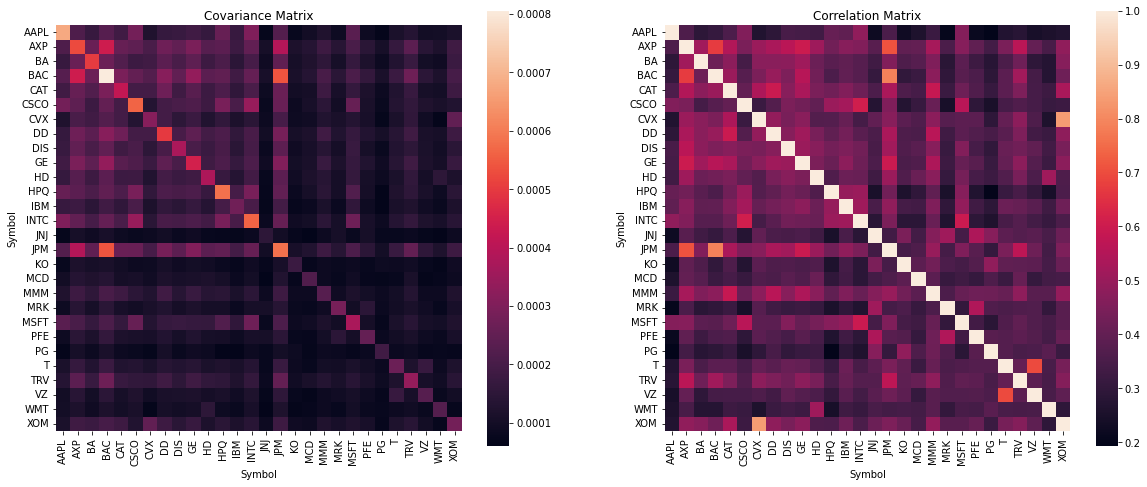

In [38]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov(),  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr(), square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

* Reordering variables group similar stocks together

/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


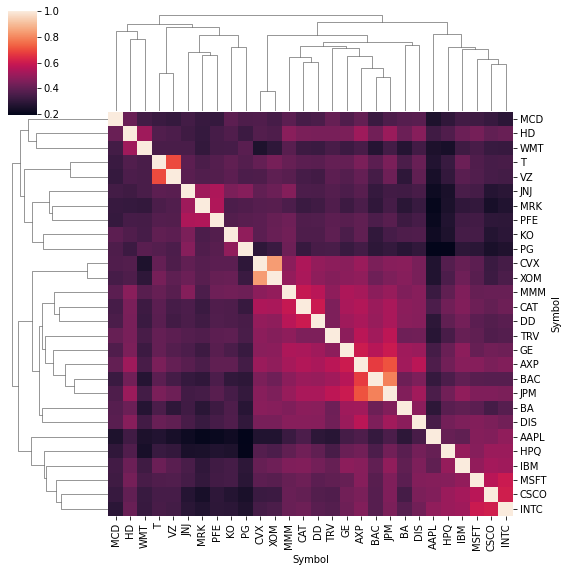

In [39]:
clmap = sns.clustermap(logret.corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

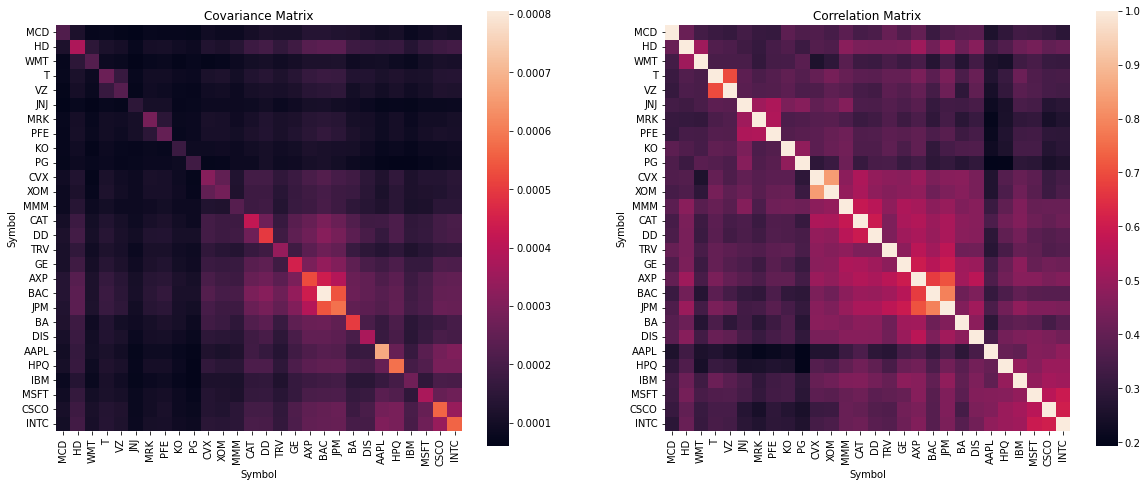

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr().iloc[ordering, ordering], square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

## Calculate Minimum Variance Portfolio

* $\Sigma$ matrix is all that is specified
* $\Sigma$ characterizes the market
* Minimize variance of portfolio $R_p$

In [41]:
import cvxpy as cvx

s, _ = sigma.shape # calculated from data

w = cvx.Variable(s) # variables
risk = cvx.quad_form(w, sigma.values)  # objective function
prob = cvx.Problem(cvx.Minimize(risk), # optimization problem 
               [cvx.sum(w) == 1])      # fully invested portfolio constraint
prob.solve()

8.537030688980672e-05

In [42]:
w.value

array([ 0.01888171, -0.07221784, -0.00908147, -0.01113491, -0.00650453,
       -0.01865739,  0.0408741 , -0.03976968,  0.01689274, -0.01371847,
       -0.02266267,  0.01256432,  0.09942205, -0.0183747 ,  0.22110177,
       -0.03230269,  0.14463123,  0.14935127,  0.08265743,  0.01089581,
        0.01605696,  0.03147711,  0.12043869,  0.00538373,  0.01516256,
        0.10794961,  0.13283893,  0.01784432])

* Positive weights indicate long positions
* Negative weights indicate [short positions](https://en.wikipedia.org/wiki/Short_(finance))
* Must sum to 1 (constraint)

* Other portfolio optimization variations:  
    http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb

* `cvxpy` package makes it easy to solve many types of problems easily
* Portfolio allocation problem with target expected return constraint:

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

* Expected returns, $\mu$, is estimated from data (also $\Sigma$)
* Investor specifies target return $\mu^*$

In [43]:
import cvxpy as cvx

s,_ = sigma.shape

w = cvx.Variable(s)
risk = cvx.quad_form(w, sigma.values)
prob = cvx.Problem(cvx.Minimize(risk), 
               [
                   cvx.sum(w) == 1,
                   mu.values@w >= 0.001
               ]) 
prob.solve()

0.0002253520396792831

In [44]:
w.value

array([ 0.33362379, -0.05160306,  0.02898955, -0.0961039 ,  0.25007014,
       -0.13857816,  0.21356185, -0.18285252,  0.04999254, -0.41519756,
        0.05636084, -0.05306768, -0.00922121, -0.1949554 ,  0.40386777,
        0.11582048,  0.03491087,  0.33346351,  0.12383764, -0.05363263,
        0.09301   , -0.02001998,  0.13934348, -0.02277297,  0.15932893,
       -0.04478692,  0.00532552, -0.0587149 ])

* Higher target return achieved with more short positions
* Constraint: $\mu^\intercal w=0.001$
* Constraint: $\mathbf{1}^\intercal w=1$.

In [45]:
w.value.sum()

1.0000000000000002

In [46]:
np.dot(mu.values,w.value)

0.001

### Making the investment

* Investing 1 dollar in a stock with 3% return over one time period makes me 3 cents:  
    $$\$1 \cdot (1 + 0.03) = 1.03$$
    
* Investing a portfolio of worth $A_0$ dollars returns,
    $$ A = A_0 (1+r_t^T w_t), $$
    where elements of $r_t$ are returns at time $t$ and $w$ is portfolio allocation

* Take allocation `w.value` and compute portfolio returns using historical returns: `logret`.

In [47]:
earned = np.dot(logret.fillna(method='bfill').values, w.value)

* Compute portfolio growth

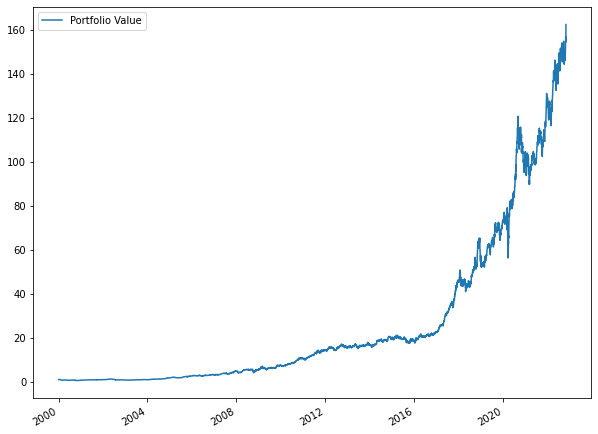

In [48]:
earnedcp = (1+earned[1:]).cumprod()
ecp = pd.DataFrame(data=earnedcp.T, index=logret.index.values[1:], columns=['Portfolio Value'])
ecp.plot(figsize=(10, 8));

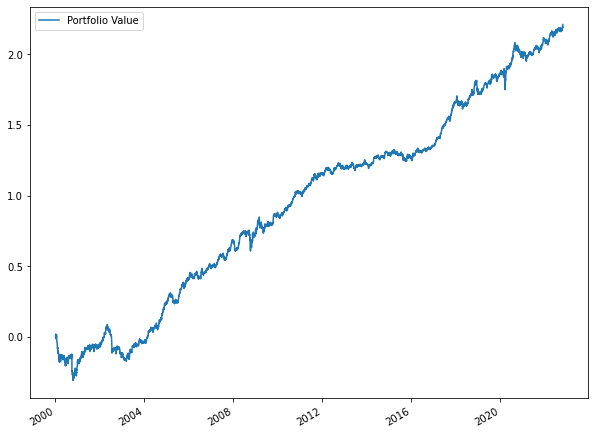

In [49]:
np.log10(ecp).plot(figsize=(10, 8));

In [50]:
ecp

,Portfolio Value
2000-01-04,0.987725
2000-01-05,1.003204
2000-01-06,1.009728
2000-01-07,1.049987
2000-01-10,1.011140
...,...
2022-10-24,155.510432
2022-10-25,156.722906
2022-10-26,154.396808
2022-10-27,158.426089


* 1 dollar invested in 2000 would be 98 dollars today?
* Unrealistic! Why?
* Having knowledge of 20 years worth of data is cheating!

### Quantify results

In [51]:
retinfo = logret.mean(axis=0).agg(['min', 'mean', 'max'])
stdinfo = logret.std(axis=0).agg(['min', 'mean', 'max'])
print('portfolio average returns:', earned.mean())
print('          average stddev :', earned.std())
print('')
print("component stocks average: minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(retinfo))
print("component stocks stddev : minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(stdinfo))

portfolio average returns: 0.0009976888116765574
          average stddev : 0.015010138281981281

component stocks average: minimum: -0.000173
                          average: 0.000256
                          maximum: 0.000907
component stocks stddev : minimum: 0.012252
                          average: 0.019118
                          maximum: 0.028380


Annual return would be:

In [52]:
(1+earned.mean())**365 - 1

0.4390380645001408

Again, unrealistic

### Qualitative Visualization of Relationships

* Correlations are stricly pairwise quantities (what about other stocks?)
* Inverse covariance

In [53]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(logret.dropna().values)
scaled_df = pd.DataFrame(scaled_df, columns=logret.columns, index=logret.index[1:])

#### Correlation Matrix: 2020

/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


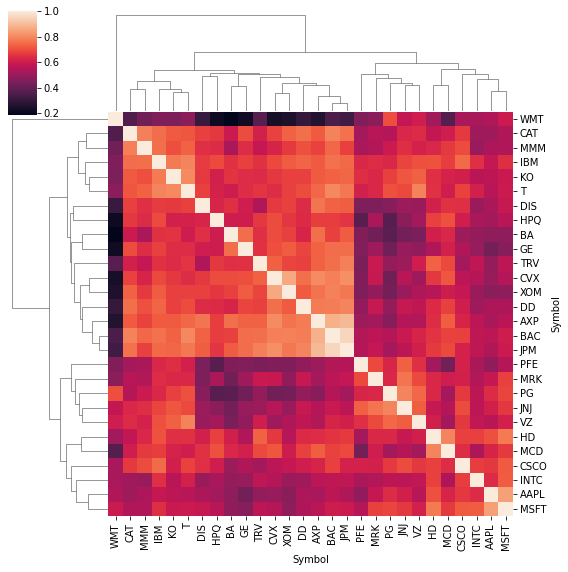

In [54]:
clmap = sns.clustermap(scaled_df.loc['2020':'2020'].corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

#### Correlation Matrix: 2019 vs. 2020

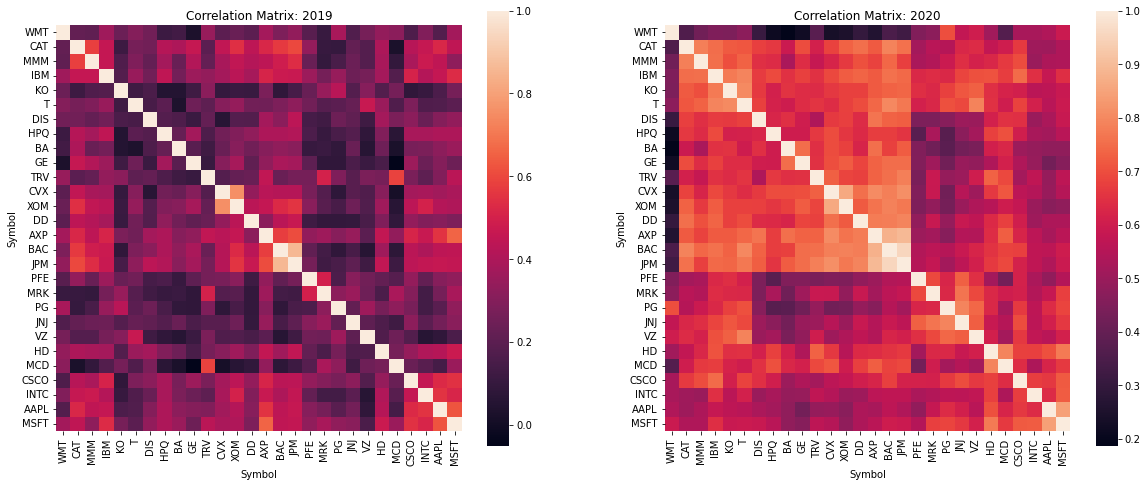

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(scaled_df.loc['2019':'2019'].corr().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Correlation Matrix: 2019')
sns.heatmap(scaled_df.loc['2020':'2020'].corr().iloc[ordering, ordering],  square=True, ax=ax[1]).set_title('Correlation Matrix: 2020')
fig.show()

### Reality check

Obviously, this cannot be realistic. What aspects were unrealistic?

1. We didn't take time into consideration: e.g. estimation of $\Sigma$ and selecting `w`.
1. We are investing with knowledge of the future returns!
1. We did not take into account transaction costs (we will have to) 
1. We did not take into account shorting requires borrowing of money
1. Is investing in stocks better than leaving our money in a savings account? What is the interest rate?

Sharpe ratio tries to quantify the added benefit, i.e., excess returns, of investing in the volatile market by accounting for the volatility:
$$\text{Sharpe ratio}=\frac{E\left[R_{p}-R_{f}\right]}{\sigma_{p}}$$
where $R_f$ is the risk-free rate.

### Other considerations

1. Picking component stocks (choosing what to invest in)
    1. Playing the role of the fund manager
    1. Expertise about a specific market
    1. Warren Buffet says stick with long term _value_ investing strategies
    1. High-frequency trading makes money by constantly shuffling investments and making incremental returns
    1. Where is the middle ground? i.e., choosing strategies
1. Choosing monitoring strategies (keeping an eye out for changes in the market)
    1. Estimation of $\Sigma$ becomes challenging with shorter historical data
    1. "Regularized" estimates of $\Sigma$: Ledoit-Wolfe, Condition number, Sparsity inducing, Low-rank
    1. How big of a change in the market is signficant change?
    1. Where to look for a change? Component stocks? Market indices? Economic indicators? Consumer sentiment? Policy changes?
    1. Deciding when to take action. How big of a change warrants an action? (Actions cost money)
1. Choosing rebalancing strategy (deciding when to shuffle your investments)  
    1. Fixed intervals? dynamic intervals? 
    1. Allowing for shorts?
    1. If many component stocks, do you trade all of them even if the change is small? etc.

## Other optimization problems for modeling and learning

1. [Online advertising](https://github.com/UCSB-PSTAT-134-234/Spring2019/blob/master/labs/lab05/lab05.ipynb)
1. [Trend filtering](https://web.stanford.edu/~boyd/l1_tf/), [CVX example](https://www.cvxpy.org/examples/applications/l1_trend_filter.html)
1. [Catching a smuggler](https://www.cvxpy.org/examples/applications/interdiction.html)
1. [Estimating sparse inverse covariance matrix](https://www.cvxpy.org/examples/applications/sparse_covariance_est.html)
1. [Max-flow, Min-cut problem](https://www.cvxpy.org/examples/applications/OOCO.html)
1. Many more!!